# Binær klassifisering ved hjelp av et nevralt nettverk

## Introduksjon

I denne oppgaven skal det utføres en binær klassifisering av ulike typer bilder. Modellen som skal brukes er et nevralt nettverk med en forholdsvis beskjeden dybde. 
$\color{red}{Mer \, spesifikt \, om \, hvordan \, modellen \, er \, bygget \, opp?}$

Tilnærmingen til problemet er todelt: 
* En treningsfase der parametrene assosiert med hver transformasjon som gir lavest mulig avvik finnes. Avviket beregnes ved hjelp av en kostfunksjon,som benytter seg av et sett med labels. Dette er essensielt en liste over de ulike punktenes reelle binære klassifisering, slik at modellen sin klassifisering kan sammenlignes med denne. 
* En valideringsfase der bilder som ikke ble brukt i treningsfasen transformeres med parameterne som ble funnet. Herfra kan man trekke en konklusjon om modellen klassifiserer bildene på en god måte eller ikke. 

I testproblem 1 skal punkter i planet klassifiseres. Det skal skilles mellom to typer punkter. Her er de valgt til å være henholdsvis røde og blå. "Bildet" i dette problemet er et punkt, kun beskrevet av to koordinater $(x,y)$. Modellen skal dermed trenes til å avgjøre om et vilkårlig punkt er rødt eller blått.

I testproblem 2 skal siffer fra MNIST klassifiseres. Her er det snakk om virkelige bilder med lav oppløsning. Størrelsen på bildene er 28 x 28 piksler. Bildene i settene fra MNIST består av siffer fra 0-9, dvs 10 ulike klasser av bilder. For at dette skal passe inn i vår binære klassifiseringsmodell holder vi oss til kun to forskjellige siffer, som for eksempel 4 og 9. 


## Testproblem 1 - punkter i planet


#### Functions and algorithm

In [46]:
import math
from plotting import *
from spirals import *
import pickle

#Prøver dette i stedet!
#%load plotting.py 
#%load spirals.py

def sigma(x):
    return np.tanh(x)

def sigma_der(x):
    return np.cosh(x)**(-2)

def eta(x):
    return 0.5*(1+np.tanh(x/2))

def eta_der(x):
    return np.e**(x)*(np.e**(x)+1)**(-2)

def adam_method(x, x_der, m_jn, v_jn, j):
    beta_1 = 0.9
    beta_2 = 0.999
    alfa = 0.01
    epsilon = 1e-8
    m_j = beta_1*m_jn + (1-beta_1)*x_der
    v_j = beta_2*v_jn + (1-beta_2)* (x_der*x_der)
    m_hatt_j = m_j/(1-beta_1**(j))
    v_hatt_j = v_j/(1-beta_2**(j))
    val = alfa*m_hatt_j/(np.sqrt(v_hatt_j) + epsilon)
    x -= val
    return x, m_j, v_j

def plain_vanilla(x,x_der, tau):
    x -= tau*x_der
    return x

def set_random_parameters(K, d):
    ''' W_k er en dxd matrise og  (2x2 for leketøysmodellen)
        b_k er en dx1 vektor elementer for hver k  (2x1 for leketøysmodellen)
    ''' 
    W_k = np.random.randn(K,d,d)
    b_k = np.random.randn(K,d,1)  
    omega = np.random.randn(d)     
    my = np.random.rand() 
    return W_k, b_k, omega, my


def update_parameters(x, x_der, m_jn, v_jn, tau, j, method="Adam"):
    ''' Updates all parameters ''' 
    if method == "Adam":
        parameter, m_j, v_j = adam_method(x,x_der, m_jn, v_jn, j)
        return parameter, m_j, v_j
    elif method == "Plain":
        x = plain_vanilla(x,x_der, tau)
        return x

def calculate_YKk(Y_Kk, b_k_dim, b_k, K, h, sigma, W_k):
    for i in range(K):
        b_k_dim[i,:,:] = b_k[i,:,:]   
        Y_Kk[i+1,:,:] = Y_Kk[i,:,:] + h*sigma(W_k[i,:,:] @ Y_Kk[i,:,:] + b_k_dim[i,:,:])
    return Y_Kk

def calculate_P_k(omega, Z, c, eta_der, YT_k, my):
    ''' Calculates part (7) of gradient '''
    P_k = np.outer(omega,(Z-c)*eta_der(YT_k @ omega + my)) #Blir en dxI matrise
    return P_k

def calculate_projection_derivatives(eta_der, YT_k, omega, Z, c, Y_Kk, my):
    ''' Calculates parts of gradient (5) and (6) '''
    J_der_my = eta_der(YT_k @ omega + my) @ (Z-c)    #Blir en skalar  
    J_der_omega = Y_Kk[-1,:,:] @ ((Z-c) * eta_der(YT_k @ omega + my)) #Blir en dx1 vektor
    return J_der_my, J_der_omega

def calculate_PKk(K, d, I, P_k, h, W_k, b_k_dim, Y_Kk):
    ''' Calculates P_(k-1) from (8) '''
    P_Kk = np.zeros((K,d,I)) #K matriser, skal ikke ha med P_0
    P_Kk[-1,:,:] = P_k      #Legger P_k bakerst i P_Kk

    for i in range(K-1,0,-1):  #Starter på P_k(=indeks K-1) og helt til og med P_1(=indeks 0)
        P_Kk[i-1,:,:] = P_Kk[i,:,:] + h*np.transpose(W_k[i-1,:,:]) @ (sigma_der(W_k[i-1,:,:] @ Y_Kk[i-1,:,:] +b_k_dim[i-1,:,:]) * P_Kk[i,:,:])
    
    return P_Kk

def calculate_rest_of_gradient(K, d, I, P_Kk, sigma_der, Y_Kk, b_k_dim, h, W_k):
    ''' Calculates parts of gradient (9) and (10) '''
    J_der_W = np.zeros((K,d,d))
    J_der_b = np.zeros((K,d,1))
    vec_I = np.ones((I,1))  #Må gjøre vec_I til en matrise av en eller annen grunn
    #P_Kk går fra P_1(=indeks 0) til P_K(=indeks K-1)
    for i in range(K):
        val = P_Kk[i,:,:] * sigma_der(W_k[i,:,:] @ Y_Kk[i,:,:] + b_k_dim[i,:,:])
        #BLIR DET RETT INDEX PÅ P_KK I VAL? SKULLE DET IKKE VÆRT I+1? ELLER ER P_KK EN MATRISE SOM REPRESENTERER P_K+1 I HEFTET? 
        J_der_W[i,:,:] = h*(val @ np.transpose(Y_Kk[i,:,:]))
        J_der_b[i,:,:] = h*(val @ vec_I)
    return J_der_W, J_der_b

def algorithm(Y_0, c, I, d, mode="training"):
    K = 20  #antall transformajsoner, kan økes til 15-20
    h = 0.1 #skrittlengde   
    iterations = 40000  #kan økes til 40 000

    #Forberedelser:
    Y_Kk = np.zeros((K+1,d,I))  #Med K transformasjoner får vi K+1 Y_k'er
    Y_Kk[0,:,:] = Y_0
    b_k_dim = np.zeros((K,d,I))

    #Learning parameters (set random startvalues)
    if mode == "training":
        W_k, b_k, omega, my = set_random_parameters(K, d)
    elif mode == "testing":
        with open("parameters.txt", "rb") as f:
            U = pickle.load(f)
        W_k, b_k, omega, my = U[0], U[1], U[2], U[3]

    j = 1   #Må starte på 1
    J = np.zeros(iterations)

    #Til Adam-metoden:
    v_j = np.array([0,np.zeros(d),np.zeros((K,d,1)),np.zeros((K,d,d))])
    m_j = np.array([0,np.zeros(d),np.zeros((K,d,1)),np.zeros((K,d,d))])

    #Til Plain vanilla:
    tau = 0.01
    while j <= iterations:
       
        Y_Kk = calculate_YKk(Y_Kk, b_k_dim, b_k, K, h, sigma, W_k) #LAGRE I MINNET! SKAL KANSKJE SKRIVES TIL FIL?

        #Calculates Z, Y_k-transpose and cost function J
        YT_k = np.transpose(Y_Kk[-1,:,:]) #Enklere notasjon
        Z = eta(YT_k @ omega + my)  #Z er en Ix1 vektor
        J[j-1] = 0.5*np.linalg.norm(Z-c)**2 #J blir en array med iterations antall verdier
        
        P_k = calculate_P_k(omega, Z, c, eta_der, YT_k, my) #LAGRE I MINNET! SKAL KANSKJE SKRIVES TIL FIL?
        
        J_der_my, J_der_omega = calculate_projection_derivatives(eta_der, YT_k, omega, Z, c, Y_Kk, my)
        
        P_Kk = calculate_PKk(K, d, I, P_k, h, W_k, b_k_dim, Y_Kk)
        
        J_der_W, J_der_b = calculate_rest_of_gradient(K, d, I, P_Kk, sigma_der, Y_Kk, b_k_dim, h, W_k)
        
        if mode == "training":
            my, m_j[0],v_j[0] = update_parameters(my, J_der_my, m_j[0], v_j[0], tau, j)
            omega, m_j[1],v_j[1] = update_parameters(omega,J_der_omega,m_j[1],v_j[1], tau, j)
            b_k, m_j[2],v_j[2] = update_parameters(b_k,J_der_b,m_j[2],v_j[2], tau, j)
            W_k, m_j[3],v_j[3] = update_parameters(W_k,J_der_W,m_j[3],v_j[3], tau, j) 

            ''' #Vanilla blir bedre med større skrittlengde synes jeg! Men Adam virker fortsatt litt bedre!
            my = update_parameters(my, J_der_my, m_j[0], v_j[0], tau, j, "Plain")
            omega = update_parameters(omega, J_der_omega,  m_j[0], v_j[0], tau, j, "Plain")
            b_k = update_parameters(b_k,J_der_b,  m_j[0], v_j[0], tau, j, "Plain")
            W_k = update_parameters(W_k, J_der_W,  m_j[0], v_j[0], tau, j, "Plain")
            '''
        j+= 1
    
    if mode == "training":
        U = [W_k, b_k, omega, my]
        with open("parameters.txt", "wb") as f:
            pickle.dump(U, f)
    return Y_Kk, J, omega, my, iterations, Z

def last_function(grid, omega, my): #Used to plot_separation
    ''' A function that takes one argument, and S-by-2 matrix of S intermediate states in
    the network, and returns a vector of S classification values.
    It should multiply by w, add μ and evaluate 𝜂. '''
    Z = eta(np.transpose(grid) @ omega + my) 
    return Z

def forward_function(grid): #Denne kan nok endre til å samsvare med en annen function. (ev kalle den funksjonen inni denne)
    ''' A function that takes one argument, an S-by-2 matrix of S datapoints, and
    returns a vector of S classification values.'''
    b_k_dim = np.zeros((K,d,len(grid[0,:])))
    for i in range(K): 
        b_k_dim[i,:,:] = b_k[i,:,:]   
        grid_k = grid + h*sigma(W_k[i,:,:] @ grid + b_k_dim[i,:,:])
        grid = grid_k

    grid_Tk = np.transpose(grid_k)
    Z = eta(grid_Tk @ omega + my)
    return Z

def plot_cost_function_convergence(iterations, J):
    ''' Plots the convergence of the cost function as a function of the iteration index ''' 
    j_values = [i for i in range(iterations)]
    plt.figure()
    plt.plot(j_values, J)
    plt.xlabel("Iteration index j")
    plt.ylabel("Cost")
    plt.title("Convergence of cost function")
    plt.show()

def stochastic_gradient_descent(I, Y_0, chunk=50): #Denne må implementeres i algoritmen, men jeg skjønner ikke helt hvordan? :(
    ''' Made to pick out pictures to test. Modifies the Adam Descent Algorithm. ''' 
    start = np.random.randint(1,I-chunk)
    Y0_chunk = Y_0[:,start:start+chunk] #picks out 50 pictures! Important to use in MNIST-task. 
    return Y0_chunk, chunk
    
def print_successrate(Z,c, tol=0.05): #Small tolerance
    correctly_classified = 0
    for i in range(len(Z)):
        if abs(Z[i]-c[i]) <= tol:
            correctly_classified+=1
    
    print("Ratio of correctly classified points:", correctly_classified/len(c))


#### Trening


134.57222836359932 2.816945912637556e-10


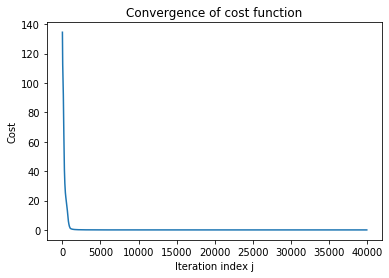

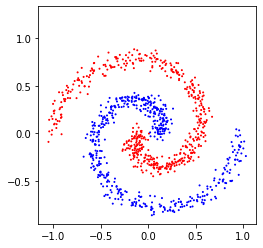

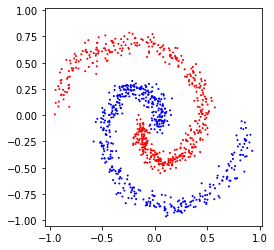

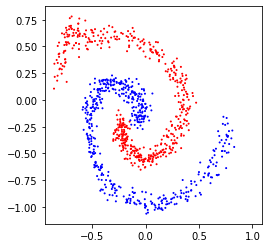

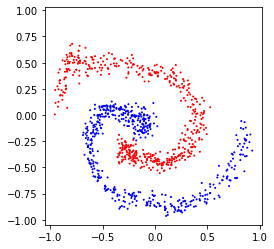

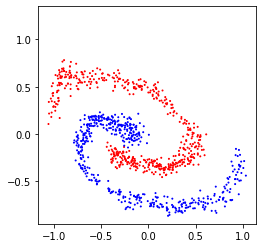

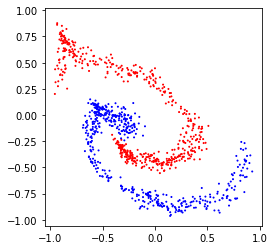

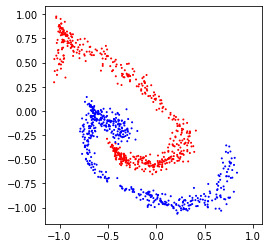

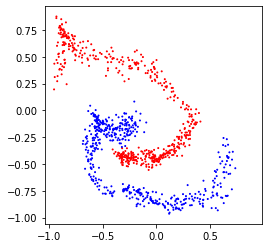

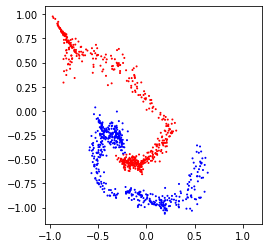

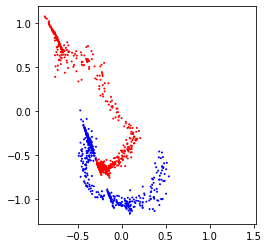

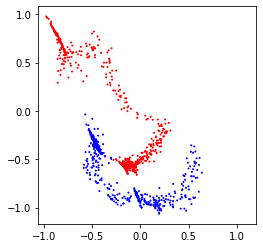

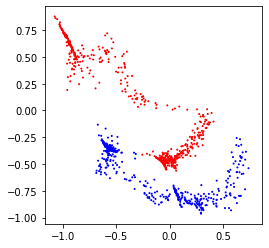

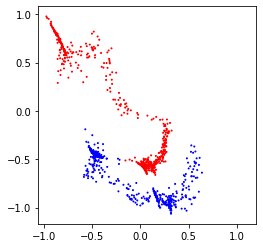

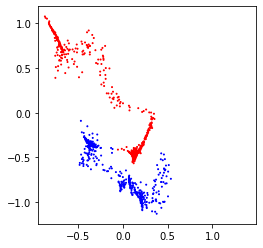

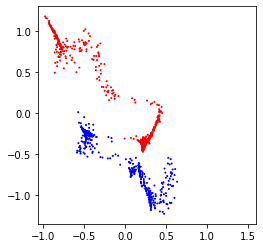

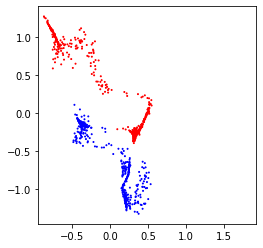

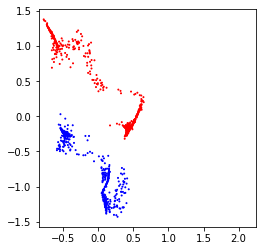

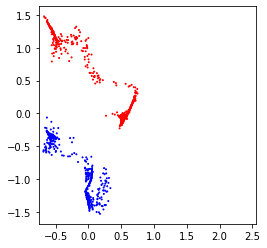

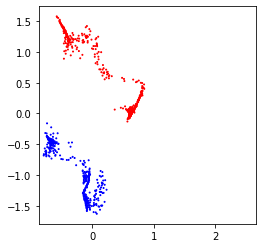

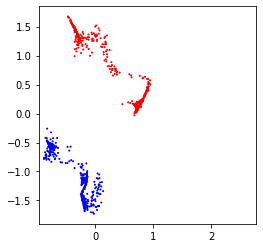

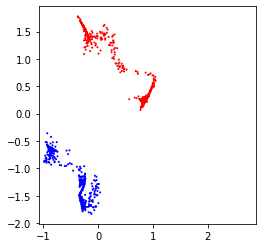

<Figure size 432x288 with 0 Axes>

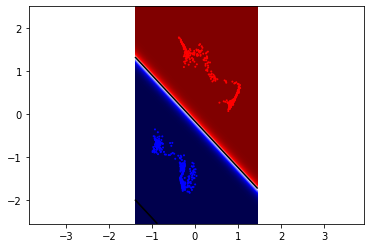

In [47]:
%timeit
I = 1000 #Number of pictures (in this case: points)
d = 2 #dimension

Y_0, c = get_data_spiral_2d(I) #Til oppgave 1: 
c = c[:,0]  #for å få en Ix1 vektor 
Y_Kk, J, omega, my, iterations, Z = algorithm(Y_0, c, I, d, "training")

#Testing er feil sånn som jeg har det nå! Skal bare regne ut Z en gang!

print(J[0],J[-1])  #god overenstemmelse 

plot_cost_function_convergence(iterations, J)

plot_progression(Y_Kk, c) 

r = 1000 #resolution of plot*
plot_separation(last_function, Y_Kk[-1,:,:], c, r, omega, my)
#plot_model(forward_function, Y_Kk[0,:,:], c, r) --> må finne en god måte å kalle denne på. Endre på forward_function litt for å få det til!


#### Testing

In [45]:
#Task 1: points in a 2d-plane
I = 1000 #Number of pictures (in this case: points)
d = 2 #dimension

Y_0, c = get_data_spiral_2d(I) #Til oppgave 1: 
c = c[:,0]  #for å få en Ix1 vektor 
Y_Kk, J, omega, my, iterations, Z = algorithm(Y_0, c, I, d, "testing")

plot_cost_function_convergence(iterations, J)

print(J[0],J[-1])  #god overenstemmelse 

plot_progression(Y_Kk, c) 

r = 1000 #resolution of plot
plot_separation(last_function, Y_Kk[-1,:,:], c, r, omega, my)
print_successrate(Z,c)
#plot_model(forward_function, Y_Kk[0,:,:], c, r) --> må finne en god måte å kalle denne på. Endre på forward_function litt for å få det til!


IndexError: index 18 is out of bounds for axis 0 with size 18

#### Resultater og analyse

Ser at resultatet er veldig godt (97.8 % av punktene er klassifisert korrekt med en toleranse på 0.05) når modellen er trent med h = 0.1, 15 lag, 1000 iterasjoner og 1000 bilder. 

Plotting av kostnadsfunksjonen mot tiden viser hvor raskt den konvergerer. 

KANSKJE LAGE EN TABELL OVER DISSE RESULTATENE?
FÅ plot_model til å fungere også, slik at jeg kan plotte modellen + separation for analysen sin del. 

## Testproblem 2 - håndskrevne siffer

#### Trening

In [20]:
from loader import *

I = 12223 #images --> kjører et beskjedent antall blant de 60000, basert på Stochastic Gradient Descent. 
#Blir ca 12000 bilder maksimalt med kun utvalg på to siffer. 
d = 784 # 28x28
Y_0, c = get_dataset()
Y_Kk, J, omega, my, iterations = algorithm(Y_0, c, I, d, "training")

/home/ajo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in power
/home/ajo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


MemoryError: Unable to allocate 873. GiB for an array with shape (784, 149401729) and data type float64

#### Testing

In [ ]:
from loader import *

I = 12223 #images --> kjører et beskjedent antall blant de 60000, basert på Stochastic Gradient Descent. 
#Blir ca 12000 bilder maksimalt med kun utvalg på to siffer. 
d = 784 # 28x28
Y_0, c = get_dataset()
Y_Kk, J, omega, my, iterations = algorithm(Y_0, c, I, d, "testing")